In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
from tensorflow import keras
from tensorflow import config
from tensorflow import data
from tensorflow import image
from pathlib import Path

In [3]:
BASE_PATH = "chest_xray"

TRAIN_PATH = Path(os.path.join(BASE_PATH, "train"))
TEST_PATH = Path(os.path.join(BASE_PATH, "test"))
VAL_PATH = Path(os.path.join(BASE_PATH, "val"))

In [4]:
#defaults

EPOCHS = 20
BATCHES = 32
IMAGE_SIZE = 224
CHANNEL = 3
INPUT_SHAPE = (BATCHES, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)

In [5]:
def create_dataset(datapath:Path):
    ds = keras.utils.image_dataset_from_directory(datapath, batch_size=BATCHES, image_size=(IMAGE_SIZE, IMAGE_SIZE))
    return ds

In [6]:
train_ds = create_dataset(TRAIN_PATH)
val_ds = create_dataset(VAL_PATH)
test_ds = create_dataset(TEST_PATH)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
NO_OF_CLASSES = len(class_names)

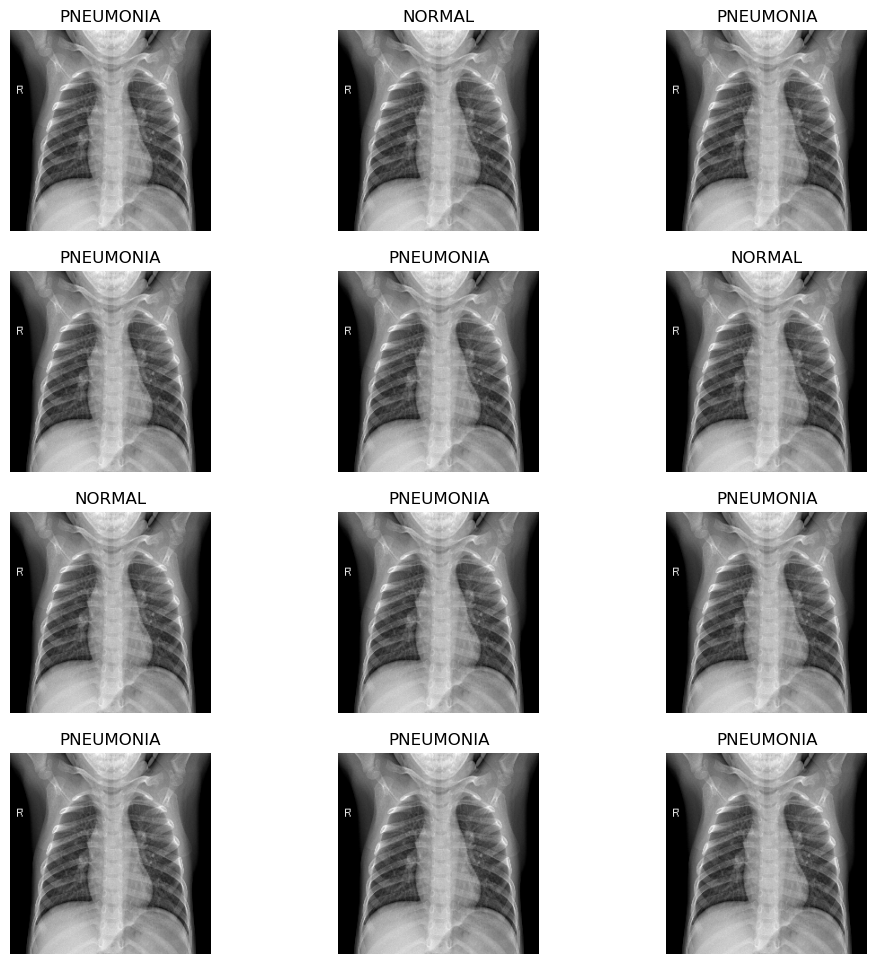

In [8]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.imshow(images[1].numpy().astype(int))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
AUTOTUNE = data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
#data augmentation layer for training

aug_layer = keras.models.Sequential()

aug_layer.add(keras.layers.RandomFlip())
aug_layer.add(keras.layers.RandomRotation(0.2))

In [11]:
aug_ds = train_ds.map(lambda x, y: (aug_layer(x, training=True), y))

In [12]:
train_ds = train_ds.concatenate(aug_ds)

In [13]:
#image preprocessing

preprocess_layer = keras.models.Sequential()

preprocess_layer.add(keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE))
preprocess_layer.add(keras.layers.Rescaling(scale=(1./255) * 255))

In [14]:
#preprocess_input = keras.applications.resnet50.preprocess_input(x * 255)(preprocess_layer.output)
#base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)

In [15]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)

In [16]:
base_model.trainable=False

In [17]:
model = keras.models.Sequential()

model.add(preprocess_layer)
model.add(base_model)
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(NO_OF_CLASSES, activation="sigmoid"))

In [18]:
adam = keras.optimizers.Adam()
bin_crossent = keras.losses.BinaryCrossentropy()
acc = keras.metrics.Accuracy()

model.compile(optimizer=adam, loss=bin_crossent, metrics=[acc])

In [19]:
#model.build(input_shape=INPUT_SHAPE)